# 序論：森林火災、フラクタル構造をした油田、拡散

## パーコレーションとは？

In [1]:
using Pkg
using Random
Pkg.add("Distributions")
using Distributions
Pkg.add("Plots")
using Plots
Pkg.add("PyPlot")
pyplot()

   Updating registry at `~/.julia/registries/General`
   Updating git-repo `https://github.com/JuliaRegistries/General.git`


Fetching: [========================================>]  100.0 %.0 %

  Resolving package versions...
   Updating `~/.julia/environments/v1.4/Project.toml`
 [no changes]
   Updating `~/.julia/environments/v1.4/Manifest.toml`
 [no changes]
  Resolving package versions...
   Updating `~/.julia/environments/v1.4/Project.toml`
 [no changes]
   Updating `~/.julia/environments/v1.4/Manifest.toml`
 [no changes]
  Resolving package versions...
   Updating `~/.julia/environments/v1.4/Project.toml`
 [no changes]
   Updating `~/.julia/environments/v1.4/Manifest.toml`
 [no changes]


Plots.PyPlotBackend()

In [2]:
"""
    binomialmap(p, dims）
    dimsで示される行列に二項分布（確率p）を生成する
"""
function binomialmap(p::Float64, dims::Tuple{Int,Int})
      return rand(Binomial(1,p),dims[1],dims[2])
end

"""
    binomialmap(p, s）
    s×sで示される正方行列に二項分布（確率p）を生成する
"""
function binomialmap(p::Float64, s::Int)
      return rand(Binomial(1,p),s,s)
end


binomialmap

In [3]:
"""
    blockmap(data; color, yflip, title, titlelocation)
    dataで示されるマップに対応して，colorで示される色で表示する
    yflipがtrueの場合は上下を反転して表示する
"""
function blockmap(data::Array{Int,2}; color::Array{Symbol}, yflip::Bool = true, 
                  title::String = "", titlelocation::String = "center")
    heatmap(data, color = color, yflip = yflip, 
            framestyle = :grid, showaxis = false, bg = :black, colorbar = :none, aspectratio = 1,
            title = title, titlelocation  = titlelocation)
end

blockmap

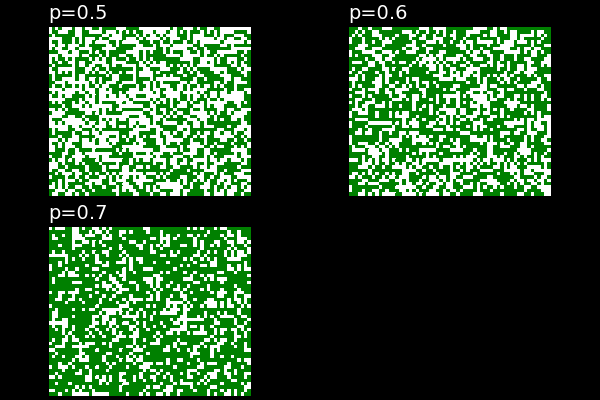

In [4]:
plt=[]
for p = 0.5:0.1:0.7
    data = binomialmap(p,(50,60))
    push!(plt,blockmap(data, color = [:white,:green], title = "p=$(p)", titlelocation = "left"))
end
plot(plt...)

## 森林火災

In [5]:
"""
    isnearest(elem)
    3×３の配列の中心位置が'１'で、最近接位置に'２'があるとき
    trueを返す
"""
function isnearest(elem::Array{Int,2})
    if elem[2,2] == 1 && 
        (any([elem[1,2],elem[3,2],elem[2,1],elem[2,3]] .== 2) ||
         any([elem[1,2],elem[3,2],elem[2,1],elem[2,3]] .== 99))    
        return true
    end
    return false
end

isnearest

In [6]:
"""
    issecondnearest(elem)
    3×３の配列の中心位置が'１'で、最近接位置および第２近接位置に'２'があるとき
    trueを返す
"""
function issecondnearest(elem::Array{Int,2})
    if elem[2,2] == 1 && (any(elem .== 2) || any(elem .== 99))
        return true
    end
    return false
end

issecondnearest

In [7]:
"""
    issecondnearest(elem)
    3×３の配列の中心位置が'１'で、最近接位置および第２近接位置に'２'が２つ以上あるとき
    trueを返す
"""
function isdoublenearest(elem::Array{Int,2})
    if elem[2,2] == 1 && count(x->x==99, elem) + count(x->x==2, elem) >=　2
        return true
    end
    return false
end

isdoublenearest

In [8]:
"""
    fireforest(p, dims, func)
    確率ｐでサイズdimに形成された森林の上端に火をつけ
    funcで示すルールに従って延焼させる。
    火種がなくなるか下端に到達させるまでのループ回数とその時のマップを返す
"""
function fireforest(p::Float64, dims::Tuple{Int,Int}, func::Function)
    data = binomialmap(p,dims)
    replace!(view(data,1,:), 1=>2)
    wdata = zeros(Int, size(data,1)+2, size(data,2)+2) 
    wdata[2:end-1,2:end-1] = data
    counts = 0
    while all(wdata[end-1,:] .!= 2 ) && any(wdata .== 2) 
        replace!(wdata, 2=>99)
        for i= 2:size(wdata,1)-1, j = 2:size(wdata,2)-1
            if func(wdata[i-1:i+1,j-1:j+1])
                wdata[i,j] = 2
            end
        end
        replace!(wdata, 99=>3)
        counts  += 1
    end
    return counts, wdata[2:end-1,2:end-1]
end 

fireforest

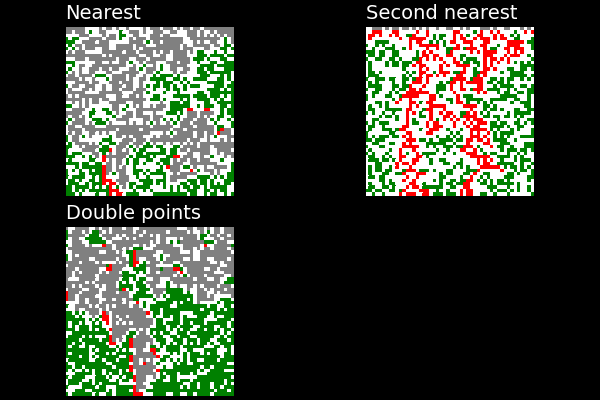

In [9]:
plt=[]
for (p,func,label) in zip([0.6,0.45,0.7],[isnearest,issecondnearest,isdoublenearest],
                            ["Nearest","Second nearest","Double points"])
    counts, data = fireforest(p,(50,50),func)
    push!(plt,blockmap(data,color=[:white, :green, :red, :gray],title = label, titlelocation = "left"))
end
plot(plt...)

In [10]:
"""
    fireforesttime(p, dims, func; nums)
    確率ｐでサイズdimに形成された森林の上端に火をつけ
    funcで示すルールに従って延焼させる。
    火種がなくなるか下端に到達させるまでのループ回数についてnum回繰り返した
    平均を返す
"""
function fireforesttime(p::Float64, dims::Tuple{Int,Int}, func::Function;nums::Int=100)
    sums = 0
    for i = 1:nums
        counts, _ = fireforest(p,dims,func)
        sums += counts
    end
    return sums/nums
end

fireforesttime

2007.532154 seconds (3.40 G allocations: 366.408 GiB, 16.63% gc time)


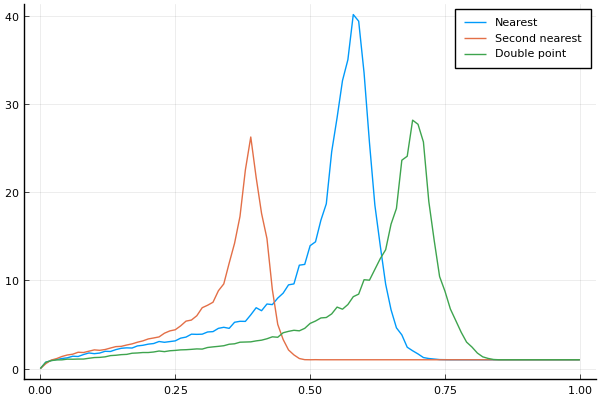

In [11]:
plot()
ps = 0:0.01:1
@time for (func, label) in zip([isnearest,issecondnearest,isdoublenearest],["Nearest","Second nearest","Double point"])
    times =[]
    for p in ps
        push!(times,fireforesttime(p,(100,100),func))
    end
    plot!(ps,times,label=label)
end
plot!()